In [7]:
import os
import sys

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl

# %matplotlib inline 可以在Ipython编译器里直接使用，功能是可以内嵌绘图，并且可以省略掉plt.show()这一步。
%matplotlib inline   

In [8]:
import auquanToolbox.dataloader as dl
from pandas.tseries.offsets import BDay


end = '2016-11-20'
start = '2010-01-01'


lookback = 2
dates = [pd.to_datetime(start) - BDay(int((lookback * 1.10) + 10)), pd.to_datetime(end)]

symbols = ['SPX']
data = dl.load_data_nologs('nasdaq', symbols ,start, end, 0)['ADJ CLOSE']
# log returns
lrets = np.log(data/data.shift(1)).dropna()

In [9]:
lrets

,SPX
2010-01-05,0.003111
2010-01-06,0.000545
2010-01-07,0.003993
2010-01-08,0.002878
2010-01-11,0.001745
2010-01-12,-0.009425
2010-01-13,0.008291
2010-01-14,0.002423
2010-01-15,-0.010882
2010-01-19,0.012422


In [10]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

In [11]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl


In [12]:
# Notice I've selected a specific time period to run this analysis
TS = lrets.SPX
res_tup = _get_best_model(TS)

order = res_tup[1]
model = res_tup[2]

c:\python27\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\python27\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\python27\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\python27\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored whe

c:\python27\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\python27\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\python27\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\python27\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored whe

c:\python27\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\python27\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\python27\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\python27\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored whe

aic: -11098.01755 | order: (3, 0, 3)


c:\python27\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [ ]:
# 一定要用NP.log，目的：
# 1、实现arima的差分使然
# 2、相应的log判断大小于0

lrets = np.log(data/data.shift(1)).dropna()

In [16]:
order

(3, 0, 3)

In [14]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(TS, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                          SPX   R-squared:                      -0.001
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                            GARCH   Log-Likelihood:                4916.30
Distribution:      Standardized Student's t   AIC:                          -9814.59
Method:                  Maximum Likelihood   BIC:                          -9765.47
                                              No. Observations:                 1733
Date:                      Sun, Aug 19 2018   Df Residuals:                     1724
Time:                              08:00:21   Df Model:                            9
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

c:\python27\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


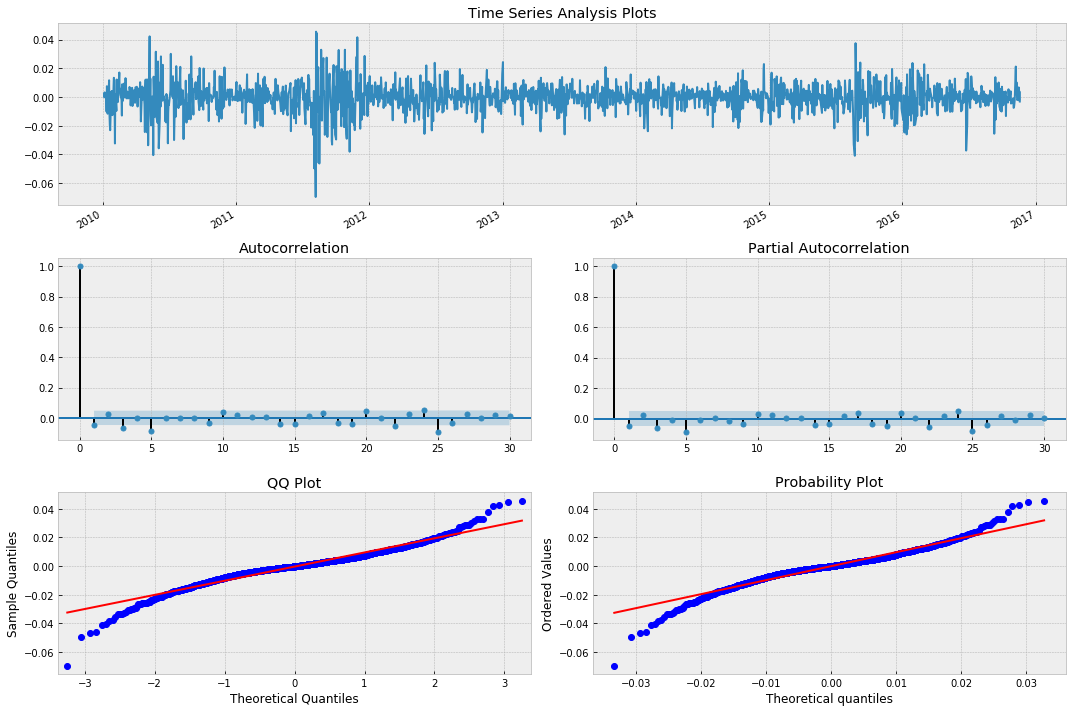

In [15]:
tsplot(res.resid, lags=30)

In [9]:
out = res.forecast(horizon=1, start=None, align='origin')
print(out.mean.iloc[-1])
print(out.variance.iloc[-1])

h.1    0.000595
Name: 2016-12-30 00:00:00, dtype: float64
h.1    0.000944
Name: 2016-12-30 00:00:00, dtype: float64


In [15]:
print out